# Multiclass Classification

In [20]:
import pandas as pd
import numpy as np
import math
from sklearn.metrics import roc_auc_score,roc_curve,plot_roc_curve
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

In [77]:
df=pd.read_csv("winequality-red.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [78]:
df['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [80]:
df['quality']=df['quality'].apply(lambda x:str(x))

In [81]:
X=df.drop('quality',axis=1)
y=df.quality

In [82]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,stratify=df['quality'])

In [83]:
my_pipeline=Pipeline([('std_sc',StandardScaler()),
                      ('clf',RandomForestClassifier(n_estimators=300,class_weight='balanced',random_state=23))])

In [84]:
my_pipeline.fit(X_train, y_train)
y_pred = my_pipeline.predict(X_test)
y_proba = my_pipeline.predict_proba(X_test)

In [85]:
my_pipeline.classes_

array(['3', '4', '5', '6', '7', '8'], dtype=object)

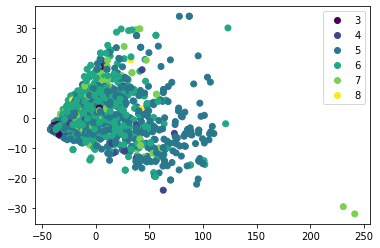

In [29]:
## Visualization of classes
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
Xt = pca.fit_transform(X)
plot = plt.scatter(Xt[:,0], Xt[:,1], c=y)
plt.legend(handles=plot.legend_elements()[0], labels=[3, 4, 5, 6, 7, 8])
plt.show()

## OvR ROC Curves and ROC AUC
>OvR stands for “One vs Rest”, and as the name suggests is one method to evaluate multiclass models by comparing each class against all the others at the same time. In this scenario we take one class and consider it as our “positive” class, while all the others (the rest) are considered as the “negative” class.

In [86]:
def calculate_tpr_fpr(label, probability):
    fpr, tpr, _ = roc_curve(label, probability)
    return tpr,fpr



def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a treshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list


def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")



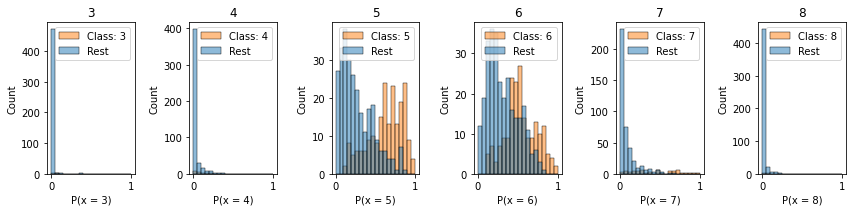

In [101]:
# Plots the Probability Distributions and the ROC Curves One vs Rest
plt.figure(figsize = (12, 8))
bins = [i/20 for i in range(20)] + [1]
classes = my_pipeline.classes_
roc_auc_ovr = {}
for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = y_proba[:, i]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(3, 6, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
plt.tight_layout()




In [102]:
# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovr:
    avg_roc_auc += roc_auc_ovr[k]
    i += 1
    print(f"{k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
print(f"average ROC AUC OvR: {avg_roc_auc/i:.4f}")

3 ROC AUC OvR: 0.6932
4 ROC AUC OvR: 0.7906
5 ROC AUC OvR: 0.8792
6 ROC AUC OvR: 0.7888
7 ROC AUC OvR: 0.9128
8 ROC AUC OvR: 0.8587
average ROC AUC OvR: 0.8206


In [89]:
# Compares with sklearn (average only)
# "Macro" average = unweighted mean
roc_auc_score(y_test, y_proba, labels = classes, multi_class = 'ovr', average = 'macro')

0.820559805943334

# ROC Curve - One vs One (OvO)

>OvO stands for “One vs One” and is really similar to OvR, but instead of comparing each class with the rest, we compare all possible two-class combinations of the dataset.

In [90]:
classes_combinations = []
class_list = list(classes)
for i in range(len(class_list)):
    for j in range(i+1, len(class_list)):
        classes_combinations.append([class_list[i], class_list[j]])
        classes_combinations.append([class_list[j], class_list[i]])
classes_combinations

[['3', '4'],
 ['4', '3'],
 ['3', '5'],
 ['5', '3'],
 ['3', '6'],
 ['6', '3'],
 ['3', '7'],
 ['7', '3'],
 ['3', '8'],
 ['8', '3'],
 ['4', '5'],
 ['5', '4'],
 ['4', '6'],
 ['6', '4'],
 ['4', '7'],
 ['7', '4'],
 ['4', '8'],
 ['8', '4'],
 ['5', '6'],
 ['6', '5'],
 ['5', '7'],
 ['7', '5'],
 ['5', '8'],
 ['8', '5'],
 ['6', '7'],
 ['7', '6'],
 ['6', '8'],
 ['8', '6'],
 ['7', '8'],
 ['8', '7']]

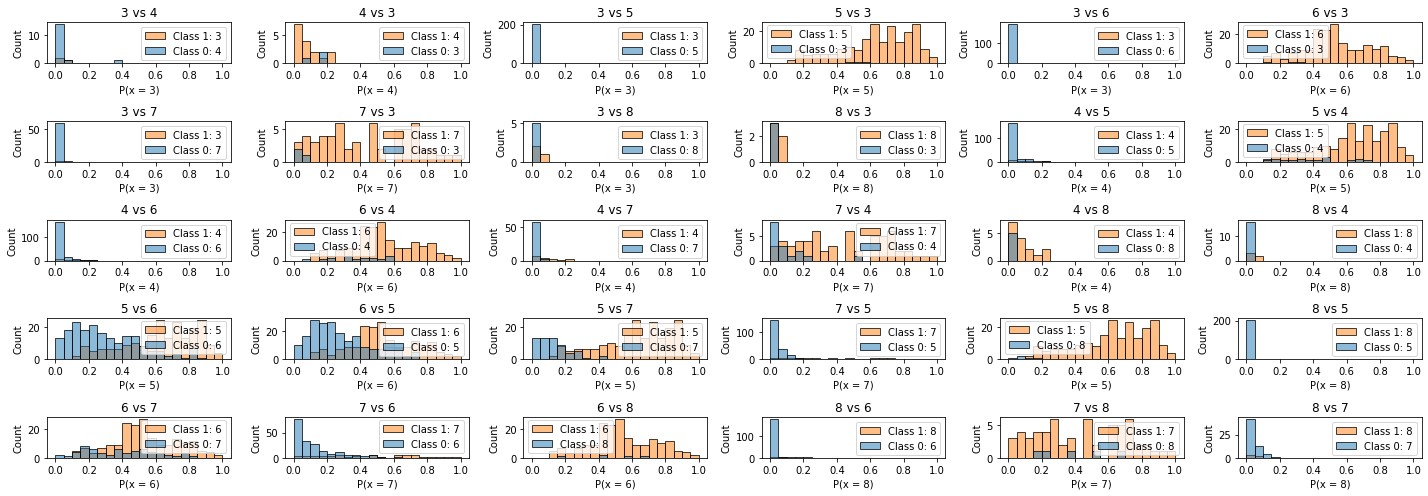

In [98]:
# Plots the Probability Distributions and the ROC Curves One vs ONe
plt.figure(figsize = (20, 7))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovo = {}

for i in range(len(classes_combinations)):
    # Gets the class
    comb = classes_combinations[i]
    c1 = comb[0]
    c2 = comb[1]
    c1_index = class_list.index(c1)
    title = c1 + " vs " +c2
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_test.copy()
    df_aux['class'] = y_test
    df_aux['prob'] = y_proba[:, c1_index]
    
    # Slices only the subset with both classes
    df_aux = df_aux[(df_aux['class'] == c1) | (df_aux['class'] == c2)]
    df_aux['class'] = [1 if y == c1 else 0 for y in df_aux['class']]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(5, 6, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(title)
    ax.legend([f"Class 1: {c1}", f"Class 0: {c2}"])
    ax.set_xlabel(f"P(x = {c1})")
    
    
    # Calculates the ROC AUC OvO
    roc_auc_ovo[title] = roc_auc_score(df_aux['class'], df_aux['prob'])
    
plt.tight_layout()

In [99]:
# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovo:
    avg_roc_auc += roc_auc_ovo[k]
    i += 1
    print(f"{k} ROC AUC OvO: {roc_auc_ovo[k]:.4f}")
print(f"average ROC AUC OvO: {avg_roc_auc/i:.4f}")

3 vs 4 ROC AUC OvO: 0.5833
4 vs 3 ROC AUC OvO: 0.2188
3 vs 5 ROC AUC OvO: 0.6618
5 vs 3 ROC AUC OvO: 0.7075
3 vs 6 ROC AUC OvO: 0.7075
6 vs 3 ROC AUC OvO: 0.9097
3 vs 7 ROC AUC OvO: 0.7778
7 vs 3 ROC AUC OvO: 0.9611
3 vs 8 ROC AUC OvO: 0.7667
8 vs 3 ROC AUC OvO: 1.0000
4 vs 5 ROC AUC OvO: 0.7287
5 vs 4 ROC AUC OvO: 0.7754
4 vs 6 ROC AUC OvO: 0.8193
6 vs 4 ROC AUC OvO: 0.7217
4 vs 7 ROC AUC OvO: 0.9302
7 vs 4 ROC AUC OvO: 0.8974
4 vs 8 ROC AUC OvO: 0.8812
8 vs 4 ROC AUC OvO: 0.9750
5 vs 6 ROC AUC OvO: 0.8572
6 vs 5 ROC AUC OvO: 0.8256
5 vs 7 ROC AUC OvO: 0.9767
7 vs 5 ROC AUC OvO: 0.9664
5 vs 8 ROC AUC OvO: 0.9912
8 vs 5 ROC AUC OvO: 0.9578
6 vs 7 ROC AUC OvO: 0.6898
7 vs 6 ROC AUC OvO: 0.8659
6 vs 8 ROC AUC OvO: 0.6167
8 vs 6 ROC AUC OvO: 0.8349
7 vs 8 ROC AUC OvO: 0.5450
8 vs 7 ROC AUC OvO: 0.5600
average ROC AUC OvO: 0.7903


In [100]:
# Compares with sklearn (average only)
# "Macro" average = unweighted mean
roc_auc_score(y_test, y_proba, labels = classes, multi_class = 'ovo', average = 'macro')

0.790343852124183